In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import h5py
from sklearn.model_selection import train_test_split
import time
from math import log10
import matplotlib.patches as patches
from skimage.metrics import structural_similarity as ssim

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
num_clusters = 2
learning_rate = 0.0005
batch_size = 1
num_epochs = 10
input_size = 496
hidden_size = 792
num_epochs = 30

# load data from mat file
with h5py.File(
    "your file path",
    "r",
) as f:
    samples = f["samples"][()]
    labels = f["y_m_d_jd_mjd_table"][3, :]  # extract day column from labels、
    samples = samples[:int(samples.shape[0]/4), :, :]
    labels = labels[:int(samples.shape[0]/4)]

# define window size and stride
window_size = 14
stride = 1

# preprocess data into input/output pairs
inputs = []
outputs = []
for i in range(window_size, samples.shape[0] - 1, stride):
    x = samples[i - window_size : i, :, :]
    y = samples[i + 1, :, :]
    inputs.append(x)
    outputs.append(y)


# input shape: 14 * 264 * 496
inputs = torch.stack([torch.from_numpy(x) for x in inputs])
outputs = torch.stack([torch.from_numpy(y) for y in outputs])

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    inputs, outputs, test_size=0.2, random_state=42
)
x_train = torch.Tensor(x_train).to(device)
y_train = torch.Tensor(y_train).to(device)
train_dataset = TensorDataset(x_train, y_train)
x_test = torch.Tensor(x_test).to(device)
y_test = torch.Tensor(y_test).to(device)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


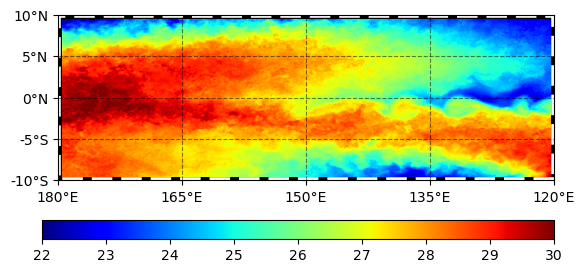

In [3]:
# graph test

# Create the figure and axis
fig, ax = plt.subplots()
extent = [180, 120, -10, 10]
heatmap = ax.imshow(samples[-5, :, :], vmin=22, vmax=30, cmap='jet', extent=extent)

rect_black = patches.Rectangle(
    (extent[1], extent[2]), extent[0] - extent[1], extent[3] - extent[2],
    linewidth=5, edgecolor='black', facecolor='none'
)
ax.add_patch(rect_black)
rect_white = patches.Rectangle(
    (extent[1], extent[2]), extent[0] - extent[1], extent[3] - extent[2],
    linewidth=4, edgecolor='white', linestyle='--', facecolor='none'
)
ax.add_patch(rect_white)

# Set ticks and labels
ax.set_xticks(np.linspace(120, 180, 5))
ax.set_yticks(np.linspace(-10, 10, 5))
ax.set_xticklabels([f"{int(label)}°{'W' if label < 0 else 'E'}" for label in np.linspace(120, 180, 5)])
ax.set_yticklabels([f"{int(label)}°{'S' if label < 0 else 'N'}" for label in np.linspace(-10, 10, 5)])

# Add colorbar
cax = fig.add_axes([0.1, 0.2, 0.8, 0.04])  # [left, bottom, width, height]
ax.grid(True, linestyle='--', color='black', alpha=0.5)
cbar = plt.colorbar(heatmap, cax=cax, orientation='horizontal', pad=-5)

plt.show()

In [4]:
# Kmeans method to split p/z sets

class CANDY_Kmeans(nn.Module):
    def __init__(self, input_size, num_clusters, hidden_size):
        super(CANDY_Kmeans, self).__init__()
        
        self.fc0 = nn.Linear(14, 3).double()

        # k-means clustering to split input into p/z sets
        self.num_clusters = num_clusters
        self.kmeans = KMeans(n_clusters=num_clusters, n_init="auto")

        # layer 1: input layer
        self.input_layer = nn.Linear(input_size, input_size).double()

        # layer 2: p set output
        self.p_output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.ReLU(True)
        ).double()
        self.Wp = nn.Parameter(
            torch.tril(torch.randn(hidden_size, hidden_size)), requires_grad=True
        ).double()
        self.Wp.data.diagonal().fill_(1)
        self.Wp_diag = nn.Parameter(
            torch.ones(hidden_size), requires_grad=True
        ).double()

        # layer 3: z set output
        self.z_output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.ReLU(True)
        ).double()
        self.Wz = nn.Parameter(
            torch.randn(hidden_size, hidden_size), requires_grad=True
        ).double()

        # layer 4: fully connected output
        self.fc1 = nn.Linear(3, 1).double()

        # MLP layer
        self.fc2 = nn.Sequential(
            nn.Linear(input_size, input_size),nn.ReLU(True)
        ).double()
        self.fc3 = nn.Linear(input_size, input_size).double()
        self.mlp_layer = nn.Sequential(
            nn.Linear(input_size, input_size), nn.BatchNorm1d(input_size), nn.ReLU(True)
        ).double()

    def kmeans_cluster(self, x):
        
        # k-means clustering to split input into p/z sets
        x = x.reshape(x.size(-1), -1)
        self.kmeans.fit_predict(x.cpu().detach().numpy())

        # Create boolean tensors indicating the positions where the labels are 0 or 1
        p_mask = self.kmeans.labels_ == 0
        z_mask = self.kmeans.labels_ == 1

        # Create p_set tensor with values from x where p_mask is True, and 0 otherwise
        p_set = torch.zeros_like(x)
        p_set[p_mask] = x[p_mask]

        # Create z_set tensor with values from x where z_mask is True, and 0 otherwise
        z_set = torch.zeros_like(x)
        z_set[z_mask] = x[z_mask]

        return p_set.double(), z_set.double()

    def forward(self, x):
        
        x = x.contiguous().view(264, 496, 14)
        x = self.fc0(x)
        x = x.view(3, 264, 496)

        # perform k-means clustering to split input into p/z sets
        p_set, z_set = self.kmeans_cluster(x)

        p_output = self.p_output_layer(p_set)

        with torch.no_grad():
            # convert Wp to lower triangular matrix
            self.Wp.data = torch.tril(self.Wp.data)
            self.Wp.data.diagonal().clamp_(min=0, max=1)
        Wp = self.Wp.double() + torch.diag(self.Wp_diag)
        p_output = p_output.to(device)
        Wp = Wp.to(device)
        p_output = p_output.view(p_output.shape[-1], -1)
        p_output = torch.mm(Wp, p_output) 

        # layer 3: z set output
        z_output = self.z_output_layer(z_set)
        z_output = z_output.view(z_output.shape[-1], -1).to(device)
        Wz = self.Wz.double().to(device)
        z_output = torch.mm(Wz, p_output)
        p_output = p_output.view(3, 1, 264, 496)
        z_output = z_output.view(3, 1, 264, 496)

        # layer 4: fully connected output
        combined_output = p_output + z_output
        output = combined_output.view(-1, 3).to(device)
        output = self.fc1(output)
        
        # new layer: MLP layer
        output = output.view(1, 264, 496).to(device)
        output = self.fc2(output)
        output = self.fc3(output)
        output = output.view(1, 264, 496)

        return output


In [6]:
# trainable p set method

class CANDY_train(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CANDY_train, self).__init__()

        # layer 1: input layer
        self.fc0 = nn.Linear(14, 3).double()

        # Initialize the p_mask hyperparameter
        self.p_mask = nn.Parameter(torch.randn(input_size), requires_grad=True).double()

        # layer 2: p set output
        self.p_output_layer = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.Wp = nn.Parameter(
            torch.tril(torch.randn(input_size, input_size)), requires_grad=True
        ).double()
        self.Wp.data.diagonal().fill_(1)
        self.Wp_diag = nn.Parameter(
            torch.ones(input_size), requires_grad=True
        ).double()

        # layer 3: z set output
        self.z_output_layer = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.Wz = nn.Parameter(
            torch.randn(input_size, input_size), requires_grad=True
        ).double()

        # layer 4: fully connected output
        self.fc1 = nn.Linear(3, 1).double()

        # MLP layer
        self.fc2 = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.fc3 = nn.Linear(input_size, input_size).double()

    def split_input(self, x):
        # Use the p_mask to split the input into p and z sets
        p_mask = self.p_mask.to(x.device) > 0
        z_mask = ~p_mask

        p_set = x * p_mask
        z_set = x * z_mask.to(x.device)

        return p_set.double(), z_set.double()

    def forward(self, x):
        x = x.contiguous().view(264, 496, 14)
        x = self.fc0(x)
        x = x.view(3, 264, 496)

        # Split input into p and z sets
        p_set, z_set = self.split_input(x)
        
        p_output = self.p_output_layer(p_set)

        with torch.no_grad():
            self.Wp.data = torch.tril(self.Wp.data)
            self.Wp.data.diagonal().clamp_(min=0, max=1)
        Wp = self.Wp.double() + torch.diag(self.Wp_diag)
        p_output = p_output.to(device)
        Wp = Wp.to(device)
        p_output = p_output.view(p_output.shape[-1], -1)
        p_output = torch.mm(Wp, p_output)

        z_output = self.z_output_layer(z_set)
        z_output = z_output.view(z_output.shape[-1], -1).to(device)
        Wz = self.Wz.double().to(device)
        z_output = torch.mm(Wz, p_output)
        p_output = p_output.view(3, 264, 496)
        z_output = z_output.view(3, 264, 496)

        combined_output = p_output + z_output
        output = combined_output.view(-1, 3).to(device)
        output = self.fc1(output)

        output = output.view(1, 264, 496).to(device)
        output = self.fc2(output)
        output = self.fc3(output)
        output = output.view(1, 264, 496)

        return output



In [7]:
# fixed p set method

class CANDY_fixed(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CANDY_fixed, self).__init__()

        # layer 1: input layer
        self.fc0 = nn.Linear(14, 3).double()

        # Initialize the p_mask hyperparameter
        p_mask = torch.zeros(input_size)
        p_mask[::2] = 1  # Set every other element to 1, creating a chess grid
        self.p_mask = nn.Parameter(p_mask, requires_grad=False).double()
        
        # layer 2: p set output
        self.p_output_layer = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.Wp = nn.Parameter(
            torch.tril(torch.randn(input_size, input_size)), requires_grad=True
        ).double()
        self.Wp.data.diagonal().fill_(1)
        self.Wp_diag = nn.Parameter(
            torch.ones(input_size), requires_grad=True
        ).double()

        # layer 3: z set output
        self.z_output_layer = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.Wz = nn.Parameter(
            torch.randn(input_size, input_size), requires_grad=True
        ).double()

        # layer 4: fully connected output
        self.fc1 = nn.Linear(3, 1).double()

        # MLP layer
        self.fc2 = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.fc3 = nn.Linear(input_size, input_size).double()

    def split_input(self, x):
        # Use the p_mask to split the input into p and z sets
        p_mask = self.p_mask.to(x.device) > 0
        z_mask = ~p_mask

        p_set = x * p_mask
        z_set = x * z_mask.to(x.device)

        return p_set.double(), z_set.double()

    def forward(self, x):
        x = x.contiguous().view(264, 496, 14)
        x = self.fc0(x)
        x = x.view(3, 264, 496)

        # Split input into p and z sets
        p_set, z_set = self.split_input(x)
        
        p_output = self.p_output_layer(p_set)

        with torch.no_grad():
            self.Wp.data = torch.tril(self.Wp.data)
            self.Wp.data.diagonal().clamp_(min=0, max=1)
        Wp = self.Wp.double() + torch.diag(self.Wp_diag)
        p_output = p_output.to(device)
        Wp = Wp.to(device)
        p_output = p_output.view(p_output.shape[-1], -1)
        p_output = torch.mm(Wp, p_output)

        z_output = self.z_output_layer(z_set)
        z_output = z_output.view(z_output.shape[-1], -1).to(device)
        Wz = self.Wz.double().to(device)
        z_output = torch.mm(Wz, p_output)
        p_output = p_output.view(3, 264, 496)
        z_output = z_output.view(3, 264, 496)

        combined_output = p_output + z_output
        output = combined_output.view(-1, 3).to(device)
        output = self.fc1(output)

        output = output.view(1, 264, 496).to(device)
        output = self.fc2(output)
        output = self.fc3(output)
        output = output.view(1, 264, 496)

        return output


In [8]:
# layer adjusted method

class CANDY_layer_adjusted(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CANDY_layer_adjusted, self).__init__()

        # layer 1: input layer
        self.fc0 = nn.Linear(14, 3).double()

        # Initialize the p_mask hyperparameter
        self.p_mask = nn.Parameter(torch.randn(input_size), requires_grad=True).double()

        # layer 2: p set output
        self.p_output_layer = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.Wp = nn.Parameter(
            torch.tril(torch.randn(hidden_size, hidden_size)), requires_grad=True
        ).double()
        self.Wp.data.diagonal().fill_(1)
        self.Wp_diag = nn.Parameter(
            torch.ones(hidden_size), requires_grad=True
        ).double()

        # layer 3: z set output
        self.z_output_layer = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.Wz = nn.Parameter(
            torch.randn(hidden_size, hidden_size), requires_grad=True
        ).double()

        # layer 4: fully connected output
        self.fc1 = nn.Sequential(
            nn.Linear(3, 1),
            nn.ReLU(True)).double()

        # MLP layer
        self.fc2 = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(True)
        ).double()
        self.fc3 = nn.Linear(input_size, input_size).double()

    def split_input(self, x):
        # Use the p_mask to split the input into p and z sets
        p_mask = self.p_mask.to(x.device) > 0

        p_set = x * p_mask

        return p_set.double()

    def forward(self, x):
        x = x.contiguous().view(264, 496, 14)
        x = self.fc0(x)
        x = x.view(3*264, 496)

        p_set = self.split_input(x)

        with torch.no_grad():
            # convert Wp to lower triangular matrix
            self.Wp.data = torch.tril(self.Wp.data)
            self.Wp.data.diagonal().clamp_(min=0, max=1)
        Wp = self.Wp.double() + torch.diag(self.Wp_diag)
        Wp = Wp.to(device)
        p_output = torch.mm(Wp, p_set)
        p_output = self.p_output_layer(p_output)

        # layer 3: z set output
        Wz = self.Wz.double().to(device)
        z_output = torch.mm(Wz, p_output)
        z_output = self.z_output_layer(z_output)
        p_output = p_output.view(3, 264, 496)
        z_output = z_output.view(3, 264, 496)

        combined_output = p_output + z_output
        output = combined_output.view(264, 496, 3).to(device)
        output = self.fc1(output)

        output = output.view(1, 264, 496).to(device)
        # output = self.fc2(output)
        output = self.fc3(output)
        output = output.view(1, 264, 496)

        return output



In [21]:
# Define the model
'''
model = CANDY_Kmeans(input_size, num_clusters, hidden_size).to(device)
model = CANDY_fixed(input_size, hidden_size).to(device)
'''
model = CANDY_train(input_size, hidden_size).to(device)

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
test_losses = []

In [ ]:
# plot the map of p/z partition

app_data = samples[-20:, :, :]
app_data = torch.tensor(app_data, dtype=torch.float32).to(device)
inputs = app_data[:14, :, :].double()
inputs = inputs.contiguous().view(264, 496, 14)
input1 = model.fc0(inputs)
input1 = input1.view(3, 264, 496)

p_set, z_set = model.kmeans_cluster(input1)

fig, ax = plt.subplots()
extent = [180, 120, -10, 10]
heatmap = ax.imshow(p_set[:, :264].cpu().detach().numpy(),vmin= -1, vmax = 1, cmap='rainbow', extent=extent)
ax.set_xticks(np.linspace(120, 180, 5))
ax.set_yticks(np.linspace(-10, 10, 5))
ax.set_xticklabels([f"{int(label)}°{'W' if label < 0 else 'E'}" for label in np.linspace(120, 180, 5)])
ax.set_yticklabels([f"{int(label)}°{'S' if label < 0 else 'N'}" for label in np.linspace(-10, 10, 5)])
cax = fig.add_axes([0.1, 0.2, 0.8, 0.04])  # [left, bottom, width, height]
cbar = plt.colorbar(heatmap, cax=cax, orientation='horizontal', pad=-5)
plt.show()


In [22]:
# define train and test function

def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, pred = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = 0
        loss += criterion(outputs, pred)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    return train_loss


def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, pred = data
            inputs = inputs.to(device)

            batch_size = inputs.size(0)
            outputs = []

            for j in range(batch_size):
                input_batch = inputs[j].unsqueeze(0)
                output_batch = model(input_batch)
                outputs.append(output_batch)

                loss = 0
                loss = criterion(
                    output_batch, pred
                )

                running_loss += loss.item()

            outputs = torch.cat(outputs, dim=0)

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    return test_loss


epoch_times = []
for epoch in range(num_epochs):
    start_time = time.time() 
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)
    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_times.append(epoch_time)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Epoch Time: {epoch_time:.2f} seconds"
    )

test_loss = test(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.6f}")

total_training_time = sum(epoch_times)
print(f"Total Training Time: {total_training_time:.2f} seconds")


Epoch 1/30, Train Loss: 200.839046, Test Loss: 12.657808, Epoch Time: 184.94 seconds
Epoch 2/30, Train Loss: 16.313479, Test Loss: 4.105262, Epoch Time: 185.68 seconds
Epoch 3/30, Train Loss: 3.479016, Test Loss: 2.551650, Epoch Time: 186.52 seconds
Epoch 4/30, Train Loss: 7.636176, Test Loss: 3.005934, Epoch Time: 188.46 seconds
Epoch 5/30, Train Loss: 1.898940, Test Loss: 1.107179, Epoch Time: 186.76 seconds
Epoch 6/30, Train Loss: 1.091928, Test Loss: 0.916765, Epoch Time: 186.71 seconds
Epoch 7/30, Train Loss: 0.878708, Test Loss: 0.719841, Epoch Time: 188.30 seconds
Epoch 8/30, Train Loss: 0.957664, Test Loss: 0.611336, Epoch Time: 188.57 seconds
Epoch 9/30, Train Loss: 0.654581, Test Loss: 1.123121, Epoch Time: 178.40 seconds
Epoch 10/30, Train Loss: 0.744586, Test Loss: 0.544600, Epoch Time: 210.30 seconds
Epoch 11/30, Train Loss: 0.575118, Test Loss: 0.486890, Epoch Time: 269.55 seconds
Epoch 12/30, Train Loss: 0.548461, Test Loss: 0.464793, Epoch Time: 271.65 seconds
Epoch 13/


tensor(0.2805, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 1 : 0.5296540002625345
PSNR 1 : 5.520154866363813
SSIM 1 : 0.9988077460323929


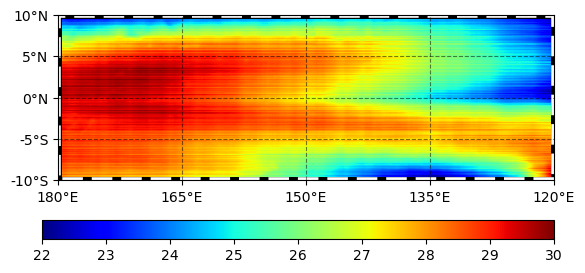

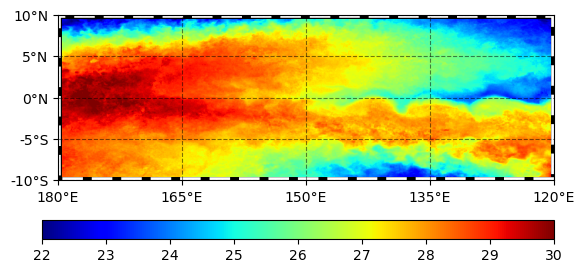

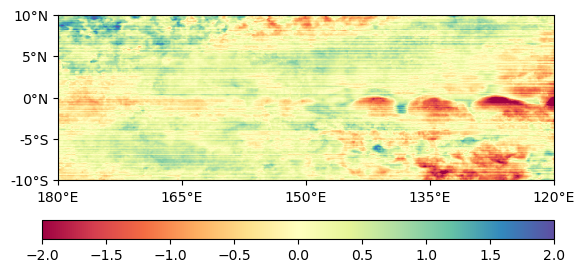


tensor(0.2848, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 2 : 0.5336913877924557
PSNR 2 : 5.45419610748049
SSIM 2 : 0.9988834604477131


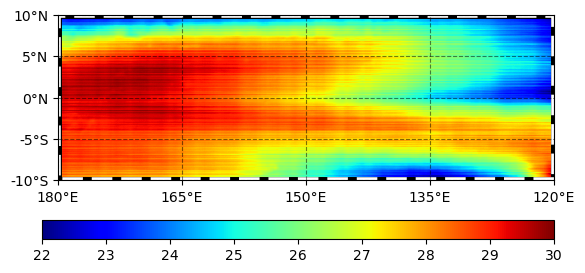

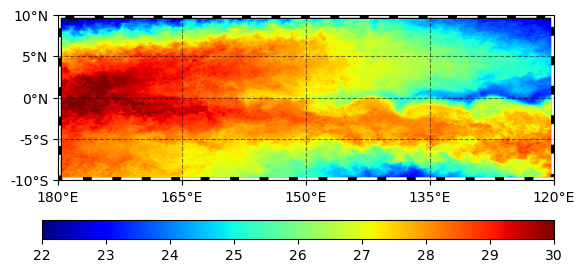

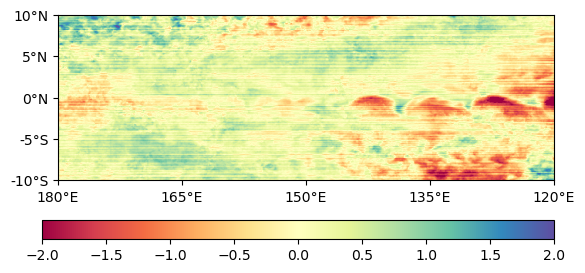


tensor(0.2761, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 3 : 0.5254753357913453
PSNR 3 : 5.588953272299882
SSIM 3 : 0.9988663969028979


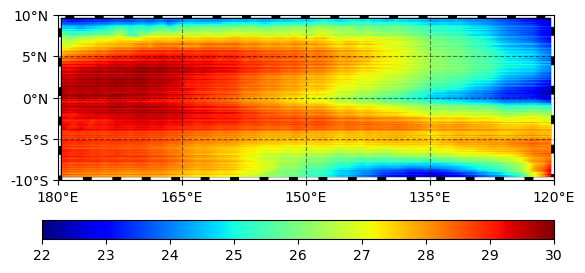

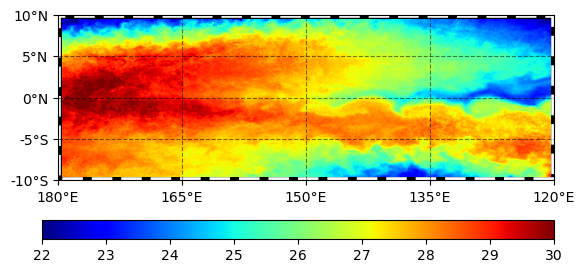

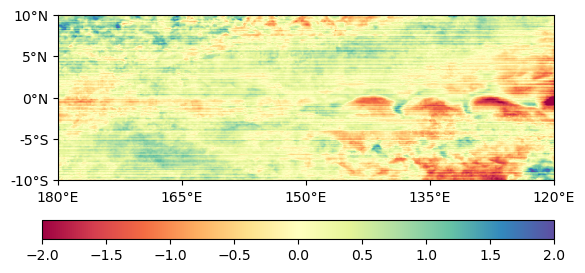


tensor(0.2600, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 4 : 0.5099067282229891
PSNR 4 : 5.850185149517405
SSIM 4 : 0.99890821715394


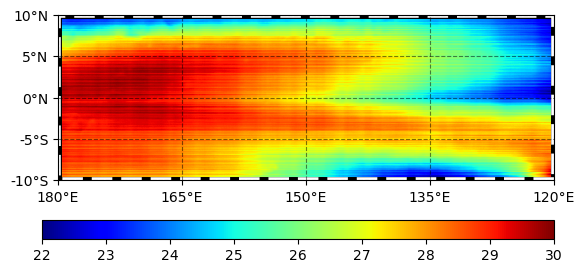

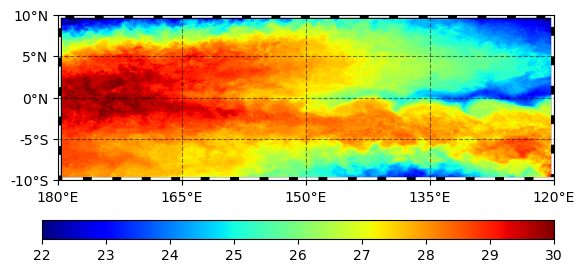

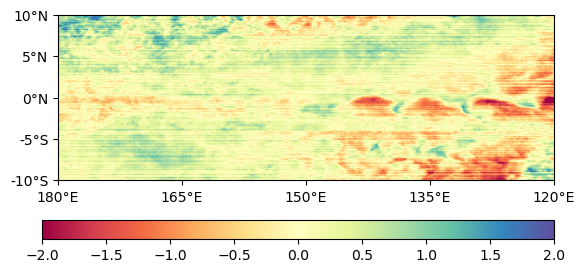


tensor(0.2700, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 5 : 0.5196443935817007
PSNR 5 : 5.685875078693283
SSIM 5 : 0.9988223264412004


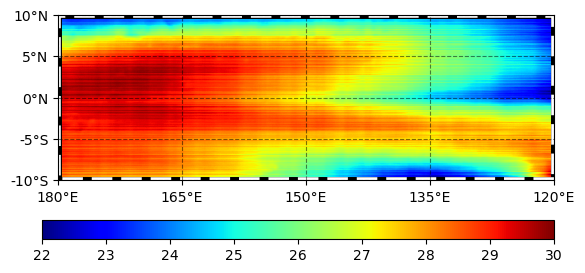

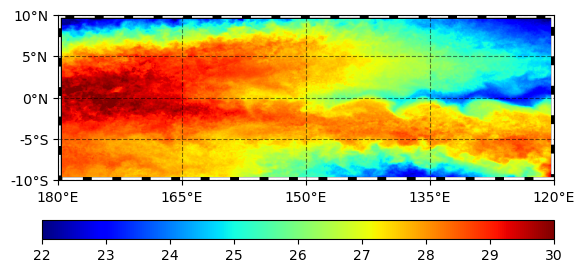

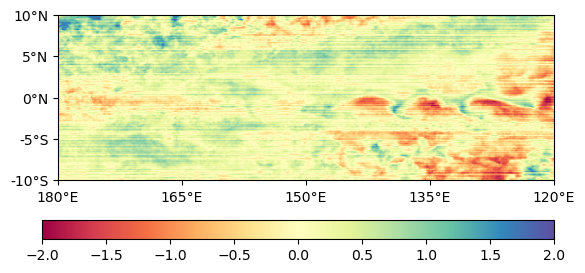


tensor(0.2766, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 6 : 0.5258893135046517
PSNR 6 : 5.582113086226218
SSIM 6 : 0.9988249175987219


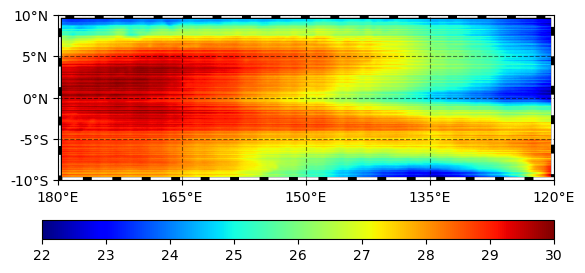

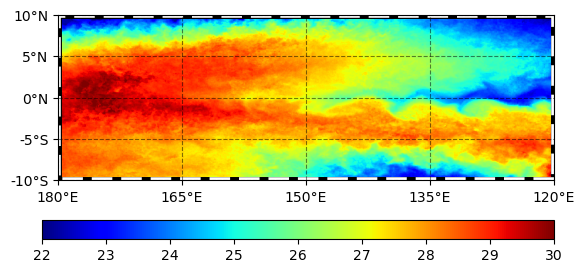

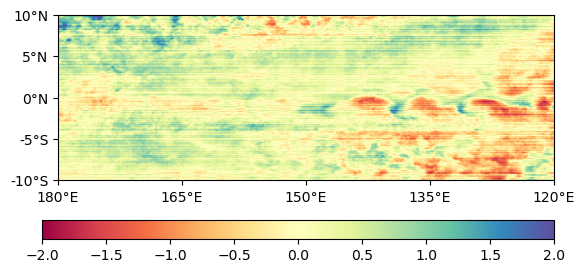


tensor(0.2894, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 7 : 0.5379753974714443
PSNR 7 : 5.384751698073874
SSIM 7 : 0.9987162647674853


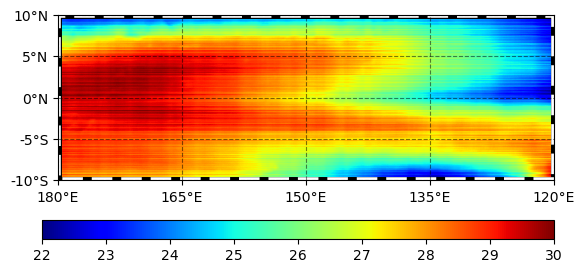

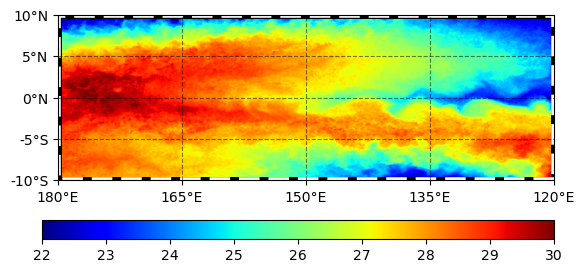

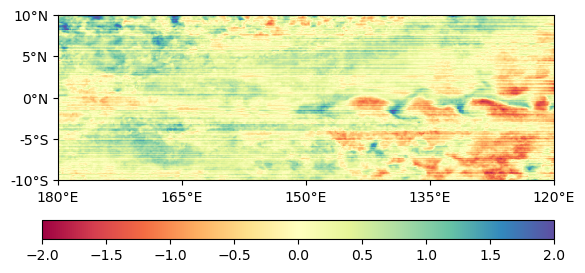


tensor(0.3029, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 8 : 0.5503498361640101
PSNR 8 : 5.187223169506562
SSIM 8 : 0.9987692566432638


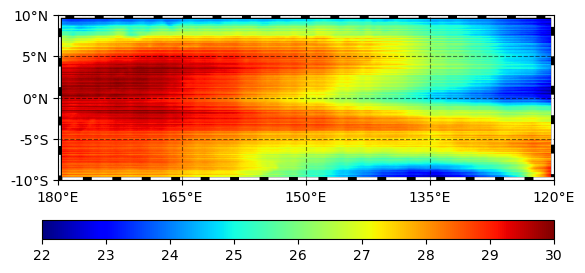

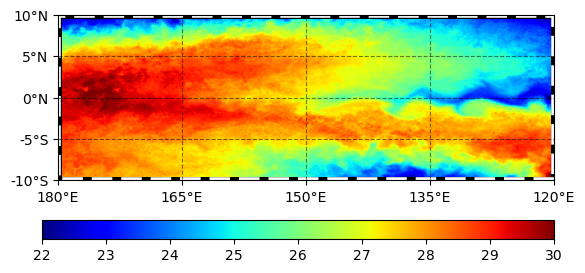

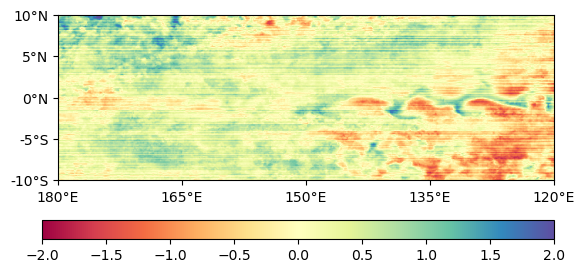


tensor(0.3107, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 9 : 0.5574332272518824
PSNR 9 : 5.076142952064923
SSIM 9 : 0.9987550188640386


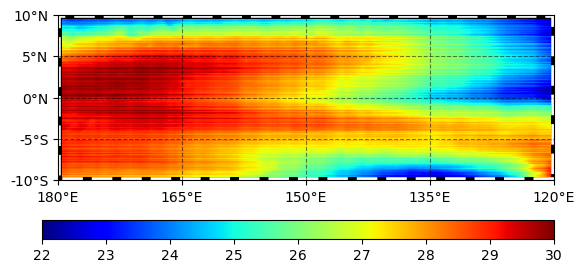

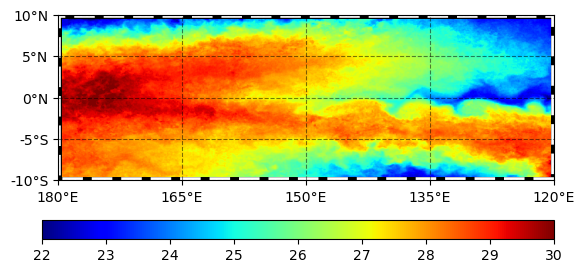

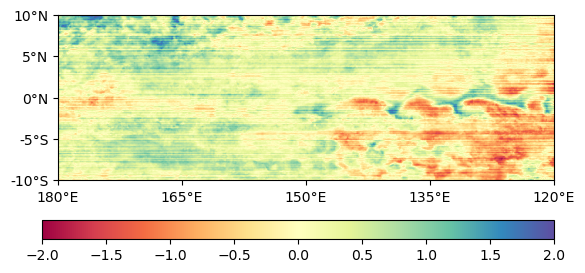


tensor(0.3346, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
RMSE 10 : 0.5784269586613098
PSNR 10 : 4.755029482838783
SSIM 10 : 0.9987619269164826


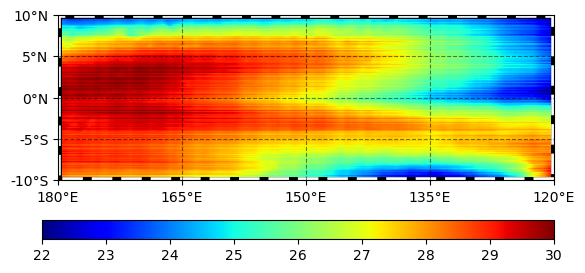

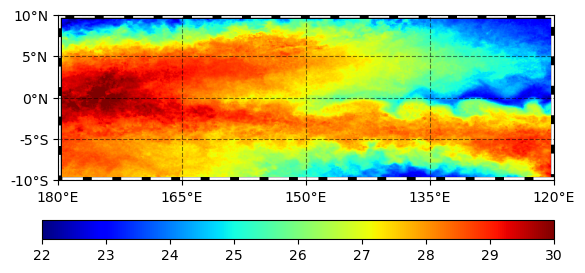

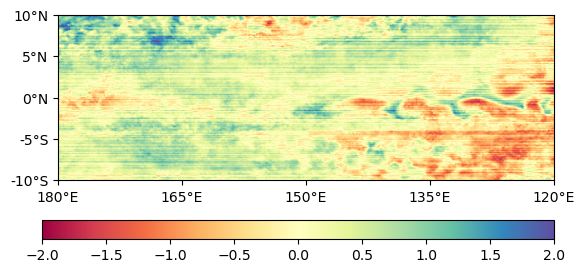

In [23]:
# define and run app function

input_total = 496
app_loss = 0

def app(model):
    # load application data
    app_data = samples[-34:, :, :]
    app_data = torch.tensor(app_data, dtype=torch.float32).to(device)
    # make predictions
    inputs = app_data[:14, :, :]
    for i in range(10):
        app_loss = 0
        x = inputs.double()       
        y_pred = model(x)
        y_true = app_data[15+i, :, :]  # 真实图像
        y_pred_img = y_pred[:, :, :].unsqueeze(0) 
        print()
        app_loss += criterion(y_pred, app_data[15+i, :, :])         
        print(app_loss) 
        
        # calculate RMSE
        rmse = torch.sqrt(torch.mean((y_pred[:, :, :].unsqueeze(0) - app_data[15+i, :, :]) ** 2)).item()
        print("RMSE", i+1, ":", rmse)
        inputs = torch.cat((inputs[1:, :, :], y_pred), axis=0).detach()
        y_pred = y_pred.cpu().detach().numpy()

        mse = torch.mean((y_pred_img - y_true) ** 2)
        if mse == 0:
            psnr = 100
        else:
            psnr = 20 * log10(1.0 / torch.sqrt(mse).item())
        print("PSNR", i+1, ":", psnr)

        y_true_np = y_true.cpu().detach().numpy()
        y_pred_np = y_pred_img.squeeze(0).squeeze(0).cpu().detach().numpy()
        y_true_normalized = y_true_np / y_pred_np.max()
        y_pred_normalized = y_pred_np / y_pred_np.max()
        ssim_value = ssim(y_true_normalized, y_pred_normalized, data_range=y_pred_np.max() - y_pred_np.min())
        print("SSIM", i+1, ":", ssim_value)

        # Create the figure and axis
        fig, ax = plt.subplots()
        extent = [180, 120, -10, 10]
        heatmap = ax.imshow(y_pred[0, :, :], vmin=22, vmax=30, cmap='jet', extent=extent)
        rect_black = patches.Rectangle(
            (extent[1], extent[2]), extent[0] - extent[1], extent[3] - extent[2],
            linewidth=5, edgecolor='black', facecolor='none')
        ax.add_patch(rect_black)
        rect_white = patches.Rectangle(
            (extent[1], extent[2]), extent[0] - extent[1], extent[3] - extent[2],
            linewidth=4, edgecolor='white', linestyle='--', facecolor='none')
        ax.add_patch(rect_white)
        ax.set_xticks(np.linspace(120, 180, 5))
        ax.set_yticks(np.linspace(-10, 10, 5))
        ax.set_xticklabels([f"{int(label)}°{'W' if label < 0 else 'E'}" for label in np.linspace(120, 180, 5)])
        ax.set_yticklabels([f"{int(label)}°{'S' if label < 0 else 'N'}" for label in np.linspace(-10, 10, 5)])
        cax = fig.add_axes([0.1, 0.2, 0.8, 0.04])
        ax.grid(True, linestyle='--', color='black', alpha=0.5)
        cbar = plt.colorbar(heatmap, cax=cax, orientation='horizontal', pad=-5)
        plt.show()

        # Create the figure and axis
        fig, ax = plt.subplots()
        extent = [180, 120, -10, 10]
        heatmap = ax.imshow(app_data[15+i, :, :].cpu().detach().numpy(), vmin=22, vmax=30, cmap='jet', extent=extent)
        rect_black = patches.Rectangle(
            (extent[1], extent[2]), extent[0] - extent[1], extent[3] - extent[2],
            linewidth=5, edgecolor='black', facecolor='none')
        ax.add_patch(rect_black)
        rect_white = patches.Rectangle(
            (extent[1], extent[2]), extent[0] - extent[1], extent[3] - extent[2],
            linewidth=4, edgecolor='white', linestyle='--', facecolor='none')
        ax.add_patch(rect_white)
        ax.set_xticks(np.linspace(120, 180, 5))
        ax.set_yticks(np.linspace(-10, 10, 5))
        ax.set_xticklabels([f"{int(label)}°{'W' if label < 0 else 'E'}" for label in np.linspace(120, 180, 5)])
        ax.set_yticklabels([f"{int(label)}°{'S' if label < 0 else 'N'}" for label in np.linspace(-10, 10, 5)])
        cax = fig.add_axes([0.1, 0.2, 0.8, 0.04])
        ax.grid(True, linestyle='--', color='black', alpha=0.5)
        cbar = plt.colorbar(heatmap, cax=cax, orientation='horizontal', pad=-5)
        plt.show()

        fig, ax = plt.subplots()
        extent = [180, 120, -10, 10]
        heatmap = ax.imshow(y_pred[0, :, :]-app_data[15+i, :, :].cpu().detach().numpy(), vmin=-2, vmax=2, cmap='Spectral', extent=extent)
        ax.set_xticks(np.linspace(120, 180, 5))
        ax.set_yticks(np.linspace(-10, 10, 5))
        ax.set_xticklabels([f"{int(label)}°{'W' if label < 0 else 'E'}" for label in np.linspace(120, 180, 5)])
        ax.set_yticklabels([f"{int(label)}°{'S' if label < 0 else 'N'}" for label in np.linspace(-10, 10, 5)])
        cax = fig.add_axes([0.1, 0.2, 0.8, 0.04])  # [left, bottom, width, height]
        cbar = plt.colorbar(heatmap, cax=cax, orientation='horizontal', pad=-5)
        plt.show()
        

    return y_pred

y_app = app(model)
